In [1]:
!pip install fredapi

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\rahul\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
!pip install python-dotenv

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\rahul\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
!nvidia-smi

NVIDIA-SMI has failed because you do not have suffient permissions. Please try running as an administrator.


In [4]:
import pandas as pd
import torch 
import matplotlib.pyplot as plt
from fredapi import Fred
import numpy as np

In [5]:
from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.environ["API_KEY"]

In [42]:
fred = Fred(api_key=api_key)
data = fred.get_series("NROU")
data.tail()

2033-10-01    4.236570
2034-01-01    4.230920
2034-04-01    4.225190
2034-07-01    4.219381
2034-10-01    4.213503
dtype: float64

In [43]:
data = pd.DataFrame(data,columns=['Rate'])
data.reset_index(inplace=True)
data.rename(columns={"index": "Date"}, inplace=True)
data.head()

,Date,Rate
0,1949-01-01,5.255053
1,1949-04-01,5.261516
2,1949-07-01,5.268013
3,1949-10-01,5.274564
4,1950-01-01,5.281182


In [44]:
data.loc[data['Date']=='1980-01-01']
data = data.iloc[124:]

In [45]:
data.reset_index(drop=True)
data["Date"] = data["Date"].map(lambda x: x.toordinal())
data["Date"] -= data["Date"].min()
data["Date"] /= data["Date"].max()
data.head()

,Date,Rate
124,0.000000,6.217371
125,0.004551,6.210709
126,0.009101,6.203388
127,0.013702,6.195496
128,0.018303,6.187123


In [46]:
rates_tensor = torch.from_numpy(data["Rate"].values).unsqueeze(dim=1)
dates_tensor = torch.from_numpy(data['Date'].values).unsqueeze(dim=1)

In [47]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [48]:
cut_batch = int(len(rates_tensor) * .8)

X_train = dates_tensor[:cut_batch].type(torch.float32).to(device)
y_train = rates_tensor[:cut_batch].type(torch.float32).to(device)
X_test = dates_tensor[cut_batch:].type(torch.float32).to(device)
y_test = rates_tensor[cut_batch:].type(torch.float32).to(device)


In [49]:
def plot_predictions(train_data = X_train, train_labels = y_train,
                     test_data = X_test, test_labels = y_test, predictions=None):
    plt.figure(figsize=(10,7))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")
    plt.scatter(test_data, test_labels, c='r', s=4, label="Testing data")
    if predictions is not None:
        plt.scatter(test_data, predictions, c='g', s=4, label="Predictions")
        
    plt.legend(prop={"size":12})

    plt.plot()


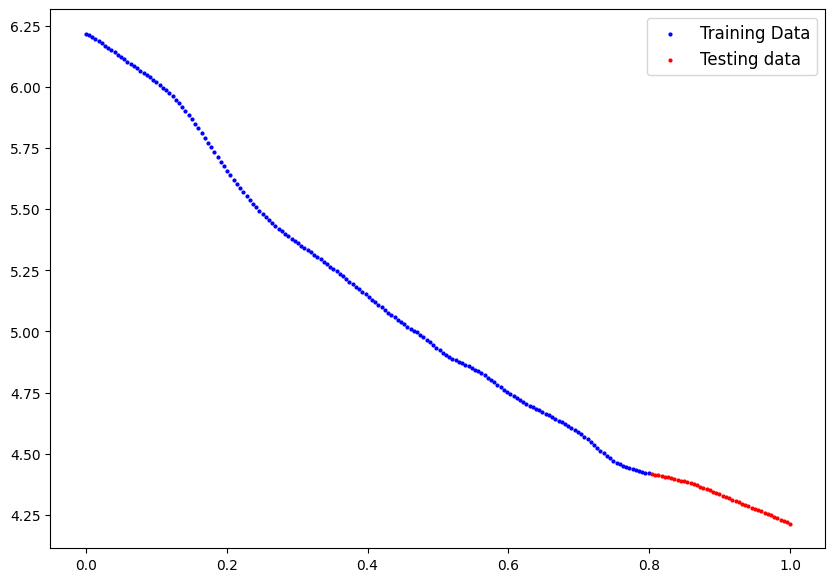

In [50]:
plot_predictions()

In [51]:
import torch.nn as nn
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self,x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [52]:
torch.manual_seed(42)
model0 = LinearRegressionModel()
list(model0.parameters())

[Parameter containing:
 tensor([[0.7645]], requires_grad=True),
 Parameter containing:
 tensor([0.8300], requires_grad=True)]

In [53]:
model0.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

In [64]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(model0.parameters(), lr=.001)

In [65]:
def noLossFr(epochs):
    for epoch in range(epochs):

        model0.train()
        
        x_pred = model0(X_train)
        
        loss = loss_fn(y_train, x_pred)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        print(loss)

noLossFr(10000)

tensor(0.0632, grad_fn=<MeanBackward0>)
tensor(0.0632, grad_fn=<MeanBackward0>)
tensor(0.0632, grad_fn=<MeanBackward0>)
tensor(0.0632, grad_fn=<MeanBackward0>)
tensor(0.0632, grad_fn=<MeanBackward0>)
tensor(0.0632, grad_fn=<MeanBackward0>)
tensor(0.0632, grad_fn=<MeanBackward0>)
tensor(0.0632, grad_fn=<MeanBackward0>)
tensor(0.0632, grad_fn=<MeanBackward0>)
tensor(0.0632, grad_fn=<MeanBackward0>)
tensor(0.0632, grad_fn=<MeanBackward0>)
tensor(0.0632, grad_fn=<MeanBackward0>)
tensor(0.0632, grad_fn=<MeanBackward0>)
tensor(0.0632, grad_fn=<MeanBackward0>)
tensor(0.0632, grad_fn=<MeanBackward0>)
tensor(0.0632, grad_fn=<MeanBackward0>)
tensor(0.0632, grad_fn=<MeanBackward0>)
tensor(0.0632, grad_fn=<MeanBackward0>)
tensor(0.0632, grad_fn=<MeanBackward0>)
tensor(0.0632, grad_fn=<MeanBackward0>)
tensor(0.0632, grad_fn=<MeanBackward0>)
tensor(0.0632, grad_fn=<MeanBackward0>)
tensor(0.0632, grad_fn=<MeanBackward0>)
tensor(0.0632, grad_fn=<MeanBackward0>)
tensor(0.0632, grad_fn=<MeanBackward0>)


tensor(0.2632)


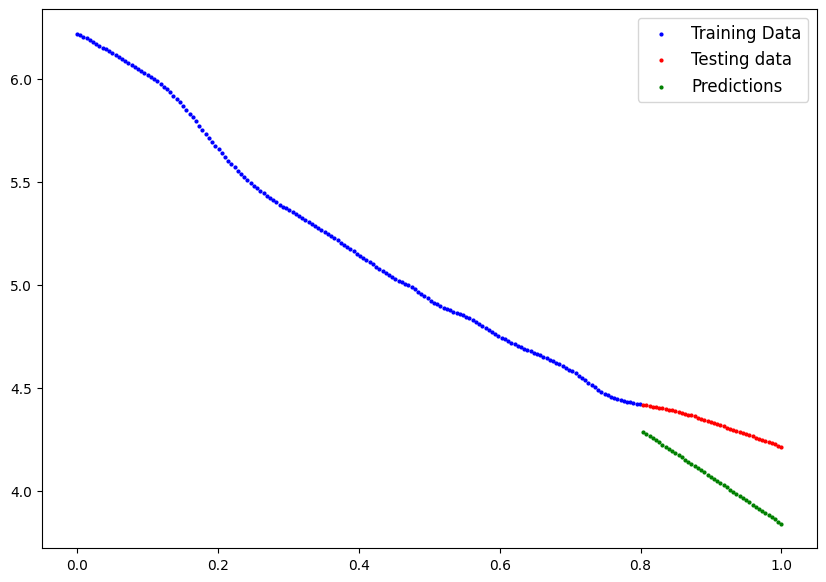

In [66]:
model0.eval()
with torch.inference_mode():
    test_preds = model0(X_test)
    loss = loss_fn(test_preds, y_test)
    plot_predictions(predictions = test_preds)
    print(loss)
